# Classification Sarkasme using LSTM
## Importing libraries

In [ ]:
import json
import requests
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from collections import Counter

In [ ]:
# --- Load Dataset from GitHub ---
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json"
response = requests.get(url)
data = [json.loads(line) for line in response.text.strip().split('\n')]

sentences = [item['headline'] for item in data]
labels = [item['is_sarcastic'] for item in data]

In [ ]:
# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# --- Preprocessing ---
tokenized = [sentence.lower().split() for sentence in sentences]

all_words = [word for sent in tokenized for word in sent]
vocab = {word: i+2 for i, (word, _) in enumerate(Counter(all_words).most_common())}
vocab['<PAD>'] = 0
vocab['<OOV>'] = 1

MAX_LEN = 40

def encode_sentence(sent, vocab, max_len=MAX_LEN):
    encoded = [vocab.get(word, vocab['<OOV>']) for word in sent]
    if len(encoded) < max_len:
        encoded += [vocab['<PAD>']] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return encoded

encoded_sentences = [encode_sentence(sent, vocab) for sent in tokenized]
X = torch.tensor(encoded_sentences)
y = torch.tensor(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# --- Dataset & DataLoader ---
class SarcasmDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SarcasmDataset(X_train, y_train)
test_ds = SarcasmDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


In [ ]:
# --- LSTM Model ---
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(hidden)
        out = self.fc(out)
        return self.sigmoid(out).squeeze()

In [ ]:
# --- Training Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(vocab_size=len(vocab), embed_dim=200, hidden_dim=256).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(10):
    model.train()
    total_loss, correct = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (output > 0.5).int()
        correct += (preds == y_batch).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracies.append(correct / len(train_ds))

    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            total_loss += loss.item()
            probs = output.cpu().numpy()
            preds = (probs > 0.5).astype(int)
            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(y_batch.cpu().numpy())
            correct += (preds == y_batch.cpu().numpy()).sum()

    avg_test_loss = total_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(correct / len(test_ds))

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Train Acc: {train_accuracies[-1]*100:.2f}% | Test Acc: {test_accuracies[-1]*100:.2f}%")


Epoch 1 | Train Loss: 0.5342 | Test Loss: 0.4665 | Train Acc: 71.21% | Test Acc: 77.14%
Epoch 2 | Train Loss: 0.3952 | Test Loss: 0.4160 | Train Acc: 81.60% | Test Acc: 80.31%
Epoch 3 | Train Loss: 0.3090 | Test Loss: 0.3938 | Train Acc: 86.54% | Test Acc: 81.65%
Epoch 4 | Train Loss: 0.2274 | Test Loss: 0.3991 | Train Acc: 90.83% | Test Acc: 82.76%
Epoch 5 | Train Loss: 0.1831 | Test Loss: 0.4382 | Train Acc: 92.88% | Test Acc: 82.80%
Epoch 6 | Train Loss: 0.1062 | Test Loss: 0.5026 | Train Acc: 96.12% | Test Acc: 81.37%
Epoch 7 | Train Loss: 0.0649 | Test Loss: 0.5944 | Train Acc: 97.97% | Test Acc: 82.83%
Epoch 8 | Train Loss: 0.0381 | Test Loss: 0.6545 | Train Acc: 98.92% | Test Acc: 82.35%
Epoch 9 | Train Loss: 0.0261 | Test Loss: 0.7069 | Train Acc: 99.34% | Test Acc: 82.57%
Epoch 10 | Train Loss: 0.0203 | Test Loss: 0.6380 | Train Acc: 99.48% | Test Acc: 83.02%


In [ ]:
# --- Final Evaluation Metrics ---
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
rec = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_probs)
train_final = train_accuracies[-1] * 100
test_final = test_accuracies[-1] * 100

print(f"\nFinal Accuracy (Test): {acc*100:.2f}%")
print(f"Final Training Accuracy: {train_final:.2f}%")
print(f"Final Testing Accuracy: {test_final:.2f}%")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")


Final Accuracy (Test): 83.02%
Final Training Accuracy: 99.48%
Final Testing Accuracy: 83.02%
Precision: 0.80
Recall: 0.82
F1 Score: 0.81
AUC: 0.91


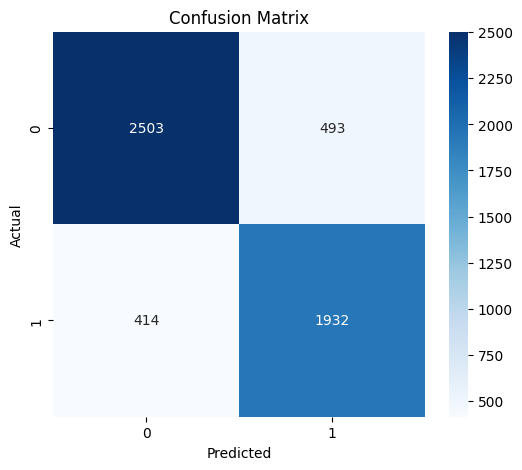

In [ ]:
# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

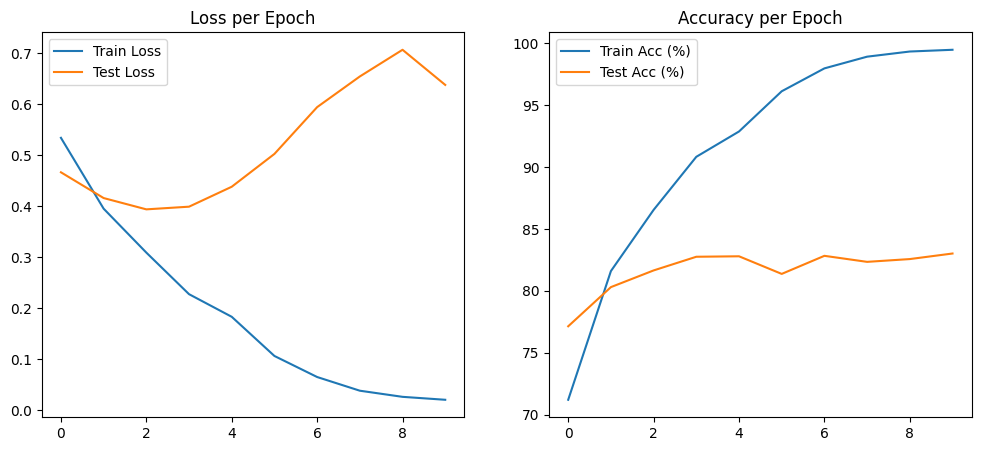

In [ ]:
# --- Accuracy & Loss Plot ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot([x * 100 for x in train_accuracies], label='Train Acc (%)')
plt.plot([x * 100 for x in test_accuracies], label='Test Acc (%)')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

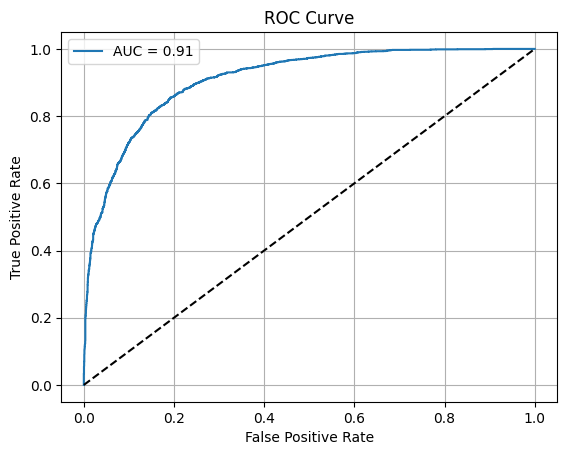

In [ ]:
# --- ROC Curve ---
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()